In [19]:
# Anderson's Capstone Project: Vehicle Crash Analysis in New York State (2019)

# Research Question: Does driving at nighttime result in more bodily injury crashes than daytime? Or does road surface condition have a bigger impact?

In [20]:
##-Process Outline--##
#--Compiling data sources--#
#--Data Cleaning--#
#--Data Execution--#
#--Conclusion--#
#--Linked Data Sources--#

In [22]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from google.colab import files
uploaded = files.upload()

Saving NY_Motor_Vehicle_Crashes_Case_Information_2019.csv to NY_Motor_Vehicle_Crashes_Case_Information_2019 (1).csv


In [24]:
from google.colab import files
uploaded = files.upload()

Saving Sunrise_Sunset_Times_NY_2019_Data.csv to Sunrise_Sunset_Times_NY_2019_Data (1).csv


In [25]:
from google.colab import files
uploaded = files.upload()

Saving GNIS_ID_NY_Data.csv to GNIS_ID_NY_Data (1).csv


In [28]:
crashes_df = pd.read_csv("NY_Motor_Vehicle_Crashes_Case_Information_2019.csv")
sunrise_sunset_df = pd.read_csv("Sunrise_Sunset_Times_NY_2019_Data.csv")
gnis_df = pd.read_csv("GNIS_ID_NY_Data.csv")

In [30]:
# Process datetime columns
crashes_df["Crash_Datetime"] = pd.to_datetime(crashes_df["Date"] + " " + crashes_df["Time"], format="%m/%d/%Y %H:%M")
crashes_df["Month"] = crashes_df["Crash_Datetime"].dt.strftime("%B")

# Sunrise/sunset strings converter to datetime.time objects
sunrise_sunset_df["Sunrise"] = pd.to_datetime(sunrise_sunset_df["Sunrise"], format="%H:%M").dt.time
sunrise_sunset_df["Sunset"] = pd.to_datetime(sunrise_sunset_df["Sunset"], format="%H:%M").dt.time

# Lookup dictionary for sunrise/sunset by month
sun_times = sunrise_sunset_df.set_index("Month")[["Sunrise", "Sunset"]].to_dict("index")

# Function to determine if crash occurred during the day or night
def determine_day_night(row):
    month = row["Month"]
    crash_time = row["Crash_Datetime"].time()
    sunrise = sun_times[month]["Sunrise"]
    sunset = sun_times[month]["Sunset"]
    return "Daytime" if sunrise <= crash_time <= sunset else "Nighttime"

# Created Day_Night function column
crashes_df["Day_Night"] = crashes_df.apply(determine_day_night, axis=1)

# Process GNIS_ID column
gnis_df["County"] = gnis_df["County"].str.upper().str.strip()
crashes_df["County Name"] = crashes_df["County Name"].str.upper().str.strip()

# Merged files based on County Name
crashes_df = crashes_df.merge(gnis_df, how="left", left_on="County Name", right_on="County")

# Cleaned GNIS_ID to remove .0 and ensure it's a string
crashes_df["GNIS_ID"] = crashes_df["GNIS_ID"].fillna(0).astype(int).astype(str)
crashes_df.loc[crashes_df["GNIS_ID"] == "0", "GNIS_ID"] = None

# Added a Count column
crashes_df["Count"] = 1

In [31]:
# Dropped non value adding columns
crashes_df.drop(columns=["Police Report", "DOT Reference Marker Location"], inplace=True)

In [32]:
# Dropped duplicate data columns resulting from data merging
crashes_df.drop(columns=["Crash_Datetime", "County"], inplace=True)

In [33]:
# Cleaned column names for consistency/ease
crashes_df.columns = crashes_df.columns.str.strip().str.lower().str.replace(" ", "_")

In [34]:
# Standardized the column to make matching easier/possible
crashes_df['crash_descriptor'] = crashes_df['crash_descriptor'].str.lower()

# Defined a set of values that indicate bodily injury
injury_keywords = {
    'injury accident',
    'fatal accident',
    'property damage & injury accident'
}

# Created injury_outcome column: True if crash_descriptor matches any injury keyword
crashes_df['injury_outcome'] = crashes_df['crash_descriptor'].isin(injury_keywords)

In [35]:
#Final columns output
crashes_df.dtypes

,0
year,int64
crash_descriptor,object
time,object
date,object
day_of_week,object
lighting_conditions,object
municipality,object
collision_type_descriptor,object
county_name,object
road_descriptor,object


In [36]:
#--Data Execution--#

#Executed variety of commands to answer the research question based on what the data said and created illustration to communicate the findings.
#Gathered total number of crashes and summarized data in various ways with "Injury Outcome" as underlying factor
#Mean injury to show ratio (%) based on time of day
#Mean injury outcome by road surface condition
#Various plot types to illustrate findings
# Bar plot
# Heatmap plot
# Point plot

In [37]:
print(crashes_df['injury_outcome'].value_counts())

injury_outcome
False    325072
True     121949
Name: count, dtype: int64


In [38]:
# Frequency count
crashes_df['injury_outcome'].value_counts(normalize=True)

,proportion
injury_outcome,
False,0.727196
True,0.272804


In [53]:
# Mean injury outcome by time of day (Day vs Night)
injury_by_daynight = crashes_df.groupby("day_night")["injury_outcome"].mean()
injury_by_daynight

,injury_outcome
day_night,
Daytime,0.276471
Nighttime,0.265228


In [54]:
# Mean injury outcome by road surface condition
injury_by_road = crashes_df.groupby("road_surface_conditions")["injury_outcome"].mean().reset_index(name='injury_outcome')
injury_by_road.sort_values('injury_outcome', ascending=False)

,road_surface_conditions,injury_outcome
3,Other,0.311828
1,Flooded Water,0.282051
0,Dry,0.281375
7,Wet,0.280751
6,Unknown,0.269019
4,Slush,0.201839
2,Muddy,0.195489
5,Snow/Ice,0.167002


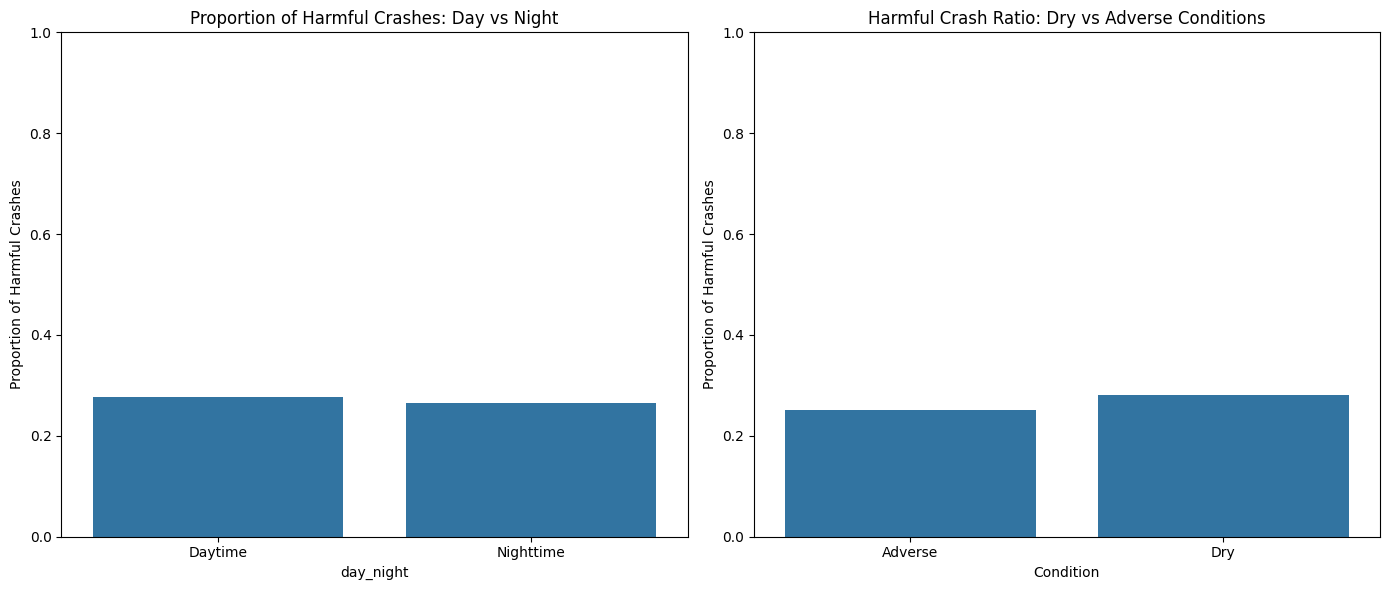

In [56]:
# Data prep
injury_by_daynight = crashes_df.groupby("day_night")["injury_outcome"].mean().reset_index(name='injury_outcome')

crashes_df['road_surface_conditions'] = crashes_df['road_surface_conditions'].str.lower()
crashes_df['road_condition_group'] = crashes_df['road_surface_conditions'].apply(lambda x: 'Dry' if x == 'dry' else 'Adverse')
ratios = crashes_df.groupby('road_condition_group')['injury_outcome'].mean().reset_index(name='Harmful Crash Ratio')
ratios = ratios.rename(columns={'road_condition_group': 'Condition'})

# To create a single side by side figure for both subplots
plt.figure(figsize=(14, 6))

# Plot 1: Harmful crashes by time of day
plt.subplot(1, 2, 1)
sns.barplot(data=injury_by_daynight, x='day_night', y='injury_outcome')
plt.title("Proportion of Harmful Crashes: Day vs Night")
plt.ylabel("Proportion of Harmful Crashes")
plt.ylim(0, 1)

# Plot 2: Harmful crash ratio by road condition
plt.subplot(1, 2, 2)
sns.barplot(data=ratios, x='Condition', y='Harmful Crash Ratio')
plt.title('Harmful Crash Ratio: Dry vs Adverse Conditions')
plt.ylabel("Proportion of Harmful Crashes")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

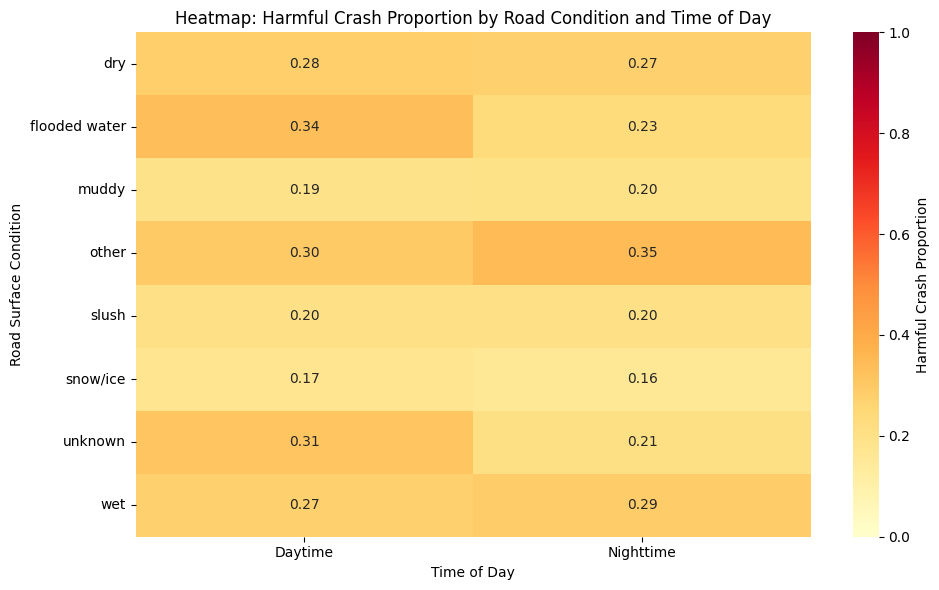

In [58]:
# Data grouping
injury_by_road_daynight = crashes_df.groupby(['road_surface_conditions', 'day_night'])['injury_outcome'].mean().reset_index()

# Heatmap (had to pivot data)
heatmap_data = injury_by_road_daynight.pivot(
    index='road_surface_conditions',
    columns='day_night',
    values='injury_outcome'
)

# Heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='YlOrRd',
    fmt=".2f",
    cbar_kws={'label': 'Harmful Crash Proportion'},
    vmin=0, vmax=1
)
plt.title("Heatmap: Harmful Crash Proportion by Road Condition and Time of Day")
plt.ylabel("Road Surface Condition")
plt.xlabel("Time of Day")
plt.tight_layout()
plt.show()

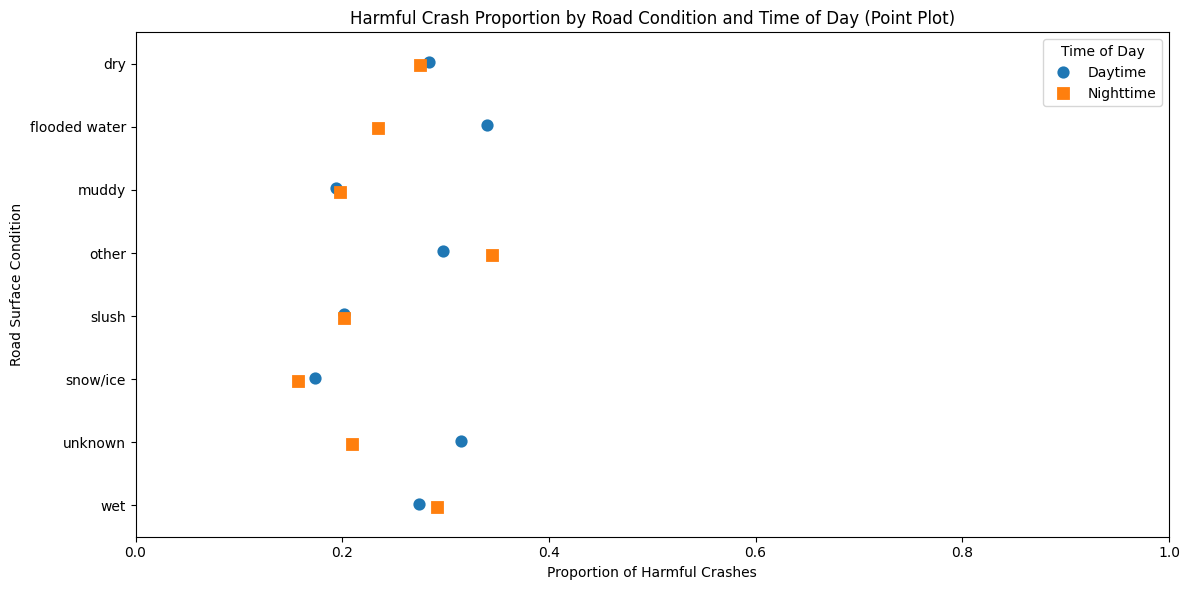

In [59]:
# Point plot
plt.figure(figsize=(12, 6))
sns.pointplot(
    data=injury_by_road_daynight,
    x='injury_outcome',
    y='road_surface_conditions',
    hue='day_night',
    dodge=True,
    markers=["o", "s"],
    linestyles=""
)
plt.title("Harmful Crash Proportion by Road Condition and Time of Day (Point Plot)")
plt.xlabel("Proportion of Harmful Crashes")
plt.ylabel("Road Surface Condition")
plt.xlim(0, 1)
plt.legend(title='Time of Day')
plt.tight_layout()
plt.show()

In [60]:
#--Conclusion--#

#The data clearly shows that oppose to popular belief, daytime driving leads to a higher bodily harm crash ratio than nighttime.
#The data also clearly shows that road surface conditions do not have a bigger impact with more badily harm crashes coming in dry conditions.

In [61]:
# Filter for non-dry (adverse) road conditions
adverse_conditions_df = crashes_df[crashes_df['road_surface_conditions'].str.lower() != 'dry']

# Calculate harmful crash ratio for adverse conditions
harmful_ratio_adverse = adverse_conditions_df['injury_outcome'].mean()

print(f"Harmful crash ratio (adverse road conditions only): {harmful_ratio_adverse:.2%}")

Harmful crash ratio (adverse road conditions only): 25.06%


In [62]:
# Make road condition lowercase to ensure consistent comparison
crashes_df['road_surface_conditions'] = crashes_df['road_surface_conditions'].str.lower()

# Separate into dry and adverse conditions
dry_df = crashes_df[crashes_df['road_surface_conditions'] == 'dry']
adverse_df = crashes_df[crashes_df['road_surface_conditions'] != 'dry']

# Ratio calculation
dry_ratio = dry_df['injury_outcome'].mean()
adverse_ratio = adverse_df['injury_outcome'].mean()

# Final results displayed
print(f"Harmful crash ratio (Dry conditions):     {dry_ratio:.2%}")
print(f"Harmful crash ratio (Adverse conditions): {adverse_ratio:.2%}")

Harmful crash ratio (Dry conditions):     28.14%
Harmful crash ratio (Adverse conditions): 25.06%


In [63]:
# Make day night lowercase to ensure consistent comparison
crashes_df['day_night'] = crashes_df['day_night'].str.lower()

# Separate into day and night dataframes
day_df = crashes_df[crashes_df['day_night'] == 'daytime']
night_df = crashes_df[crashes_df['day_night'] == 'nighttime']

# Ratio calculation
day_ratio = day_df['injury_outcome'].mean()
night_ratio = night_df['injury_outcome'].mean()

# Final results displayed
print(f"Harmful crash ratio (Daytime):   {day_ratio:.2%}")
print(f"Harmful crash ratio (Nighttime): {night_ratio:.2%}")

Harmful crash ratio (Daytime):   27.65%
Harmful crash ratio (Nighttime): 26.52%


In [64]:
#--Linked Data Sources--#
#https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Case-Information-Three-Year-/e8ky-4vqe/explore/

#https://www.sunrise-and-sunset.com/en/sun/united-states/new-york-city/2019/january

#https://gisservices.its.ny.gov/arcgis/rest/services/NYS_Civil_Boundaries/MapServer/2